In [1]:
import os
import zipfile
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
!git clone https://github.com/FelixOpolka/STGCN-PyTorch
if (not os.path.isfile("STGCN-PyTorch/data/adj_mat.npy")
            or not os.path.isfile("data/node_values.npy")):
        with zipfile.ZipFile("STGCN-PyTorch/data/METR-LA.zip", 'r') as zip_ref:
            zip_ref.extractall("data/")

Cloning into 'STGCN-PyTorch'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Receiving objects: 100% (16/16), 14.36 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import sys
from cvxopt import matrix, solvers
import numpy as np
import networkx as nx


class FGL_3SR:

    def __init__(self, beta=.1, alpha=.1, trace=1, gamma=0., X0=None, lbd0=None, H0=None, cv_crit=10e-3, maxit=1000, keep_best=True, verbose=True):
        """ initialisation function
        """
        "Values on variables of the model"
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma

        "Values on constraints"
        self.trace = trace

        "Initial guess"
        self.X0 = X0
        self.lbd0 = lbd0
        self.H0 = H0

        "Values on variables of the algorithms"
        self.maxit = maxit
        self.cv_crit = cv_crit

        "Variables of interest"
        self.H = None
        self.X = None
        self.lbd = None

        "Error sequence"
        self.err = []
        self.keep_best = keep_best

        self.verbose = verbose

    def fit(self, Y, norm='l1'):
        """ fit all the variables (X, H, Lambda)
        """
        print('FGL-3SR start')

        I_p, p, n = self.prepare_fit(Y)
        self.err.append((self.f_obj(Y)))
        err_best = self.err[-1]

        Xkeep = self.X
        Hkeep = self.H
        lbdkeep = self.lbd

        change = self.cv_crit + 1
        it = 0
        while (change > self.cv_crit) and (it < self.maxit):
            if self.verbose:
                sys.stdout.write('\r {} %'.format(
                    np.around(100. * it / self.maxit, 2)))

            "H update"
            H_old = np.array(self.H)
            if norm == 'l0':
                "norm 0 in Lagrangian form"
                self.H = self.solve_H0_closedform(Y, p, n)
            elif norm == 'l0_c':
                "norm 0 in constraint form"
                self.H = self.solve_H0_closedform_K(Y, p, n)
            elif norm == 'l1':
                "norm 1 in constraint form"
                self.H = self.solve_H1_closedform(Y, p, n)
            self.err.append((self.f_obj(Y)))

            "X update"
            self.X = self.solve_X_relaxation(Y, p)
            self.err.append((self.f_obj(Y)))

            "Lambda update"
            self.lbd = self.solve_lbd(I_p)
            self.lbd[0] = 0.
            self.err.append((self.f_obj(Y)))

            if self.err[-1] < err_best:
                err_best = self.err[-1]
                Xkeep = np.array(self.X)
                Hkeep = np.array(self.H)
                lbdkeep = np.array(self.lbd)

            change = np.sqrt(np.sum(np.square(H_old - self.H)))
            it += 1

        if self.keep_best:
            self.X = np.array(Xkeep)
            self.H = np.array(Hkeep)
            self.lbd = np.array(lbdkeep)

        return self

    def f_obj(self, Y):
        """ obj fct with current values H, X, Lambda
        """
        fval = f_obj(Y, self.X, self.H, self.lbd,
                     self.alpha, self.beta, self.gamma)
        return fval

    def grad_f_X(self, Y):
        """ gradient of the obj fct of the problem in X
            with current values H
        """
        grad_f_X_val = -2 * self.X.T.dot(Y).dot(self.H.T)
        return grad_f_X_val

    def prepare_fit(self, Y):
        """ initialisation of all the variables
        """
        solvers.options['show_progress'] = False

        p = Y.shape[0]  # nb of nodes / dim of each signal
        n = Y.shape[1]  # nb of signals

        I_p = np.identity(p)

        # Initial guess generation with complete graph
        if self.X0 is None:
            self.X0 = get_X_complete_graph(p)

        # Initial guess with complete graph and trace constraint
        if self.lbd0 is None:
            self.lbd0 = np.ones(p) * self.trace / (p - 1)
            self.lbd0[0] = 0

        # Initial guess with Y
        if self.H0 is None:
            self.H0 = np.array(Y)

        self.X = np.array(self.X0)
        self.lbd = np.array(self.lbd0)
        self.H = np.array(self.H0)

        return I_p, p, n

    def solve_H0_closedform(self, Y, p, n):
        """ H update with a closeform when l0_2 norm is choosed
        """
        H_new = np.array(Y)

        XY = self.X.T.dot(Y)
        for i in range(p):
            if np.linalg.norm(XY[i, :])**2 < self.beta * (1. + self.alpha * self.lbd[i]):
                H_new[i:] = 0
            else:
                H_new[i:] = XY[i, :] / (1. + self.alpha * self.lbd[i])

        return H_new

    def solve_H0_closedform_K(self, Y, p, n):
        """ H update with a closeform when l0_2 norm is choosed ( < K)
        """
        assert self.beta.is_integer(), 'beta is seen as K (regularization) and need to be an int'

        H_new = np.diag(1. / (1. + self.alpha * self.lbd)).dot(self.X.T).dot(Y)
        ind = np.argsort(-np.sum(H_new**2, 1))[self.beta:]
        H_new[ind] = 0.

        return H_new

    def solve_H1_closedform(self, Y, p, n):
        """ H update with a closeform when l1_2 norm is choosed
        """
        H_new = np.array(Y)

        XY = self.X.T.dot(Y)
        for i in range(p):
            if np.linalg.norm(XY[i, :]) <= self.beta / 2.:
                H_new[i, :] = 0
            else:
                H_new[i, :] = (1 - (self.beta / 2.) * (1. / np.linalg.norm(XY[i, :]))
                               ) * XY[i, :] * (1. / (1. + self.alpha * self.lbd[i]))

        return H_new

    def solve_lbd(self, I_p):
        """ lbd=diag(Lambda) update with linear programming
        """
        c, G, h, A, b, primalstart = self.compute_constraints_Diag(
            self.alpha, self.X, self.H, self.trace)

        sol = solvers.coneqp(matrix(self.gamma * I_p), c,
                             G, h, A=A, b=b, primalstart=primalstart)
        lbd_new = abs(np.array(sol['x']).ravel())

        return lbd_new

    def solve_X_relaxation(self, Y, p):
        """ X update with the relaxation method
            assuming an unique connex component
        """
        M = self.H.dot(Y.T).dot(self.X0)[1:, 1:]
        P, _, Q = np.linalg.svd(M.T, full_matrices=0)
        D_star = P.dot(Q)

        X = np.identity(p)
        X[1:, 1:] = D_star

        X_new = (self.X0).dot(X)

        return X_new

    def get_coeffs(self, order=True):
        """ return X, H, lbd and the error trajectory
        """
        if order:
            sort_ind = np.argsort(self.lbd)
            return self.X[:, sort_ind], self.H[sort_ind, :], self.lbd[sort_ind], np.array(self.err)
        else:
            return self.X, self.H, self.lbd, np.array(self.err)

    def prepare_constraints(self, alpha, X, H):
        """ prepare variables for the constraints funtion
        """
        if X is None:
            X = self.X

        if H is None:
            H = self.H

        if alpha is None:
            alpha = self.alpha

        return alpha, X, H

    def compute_constraints_Diag(self, alpha=None, X=None, H=None, trace=None):
        """ compute the constraints for the linear (quadratic) program in Lambda
            starting point: complete graph
        """
        alpha, X, H = self.prepare_constraints(alpha, X, H)
        p = X.shape[0]
        if trace is None:
            trace = p

        c = np.sum(np.square(H), 1).reshape((-1, 1))

        # Equatlity constraints
        A = np.ones((1, p))
        b = trace * np.ones((1, 1))

        # Inequality constraints
        G = np.ones((int(p * (p + 1) / 2), p))
        it = 0
        it2 = int(p * (p - 1) / 2)
        for i in range(p):
            for j in range(i, p):
                if not i == j:
                    G[it, :] = X[i, :] * X[j, :]
                    it += 1
                else:
                    e = np.zeros(p)
                    e[i] = -1
                    G[it2, :] = e
                    it2 += 1

        h = np.zeros((G.shape[0], 1))

        # starting point
        start_Lambda = np.zeros((p, 1))
        start_Lambda[1:] = trace / (p - 1)
        start_s = abs(-G.dot(start_Lambda) + .000001)
        primalstart = {"x": matrix(start_Lambda, (p, 1), 'd'), 's': matrix(
            start_s, (len(start_s), 1), 'd')}
        a = alpha * c
        a = a.astype(np.double)
        G = G.astype(np.double)
        h = h.astype(np.double)
        A = A.astype(np.double)
        b = b.astype(np.double)
        return matrix(a), matrix(G), matrix(h), matrix(A), matrix(b), primalstart


def f_obj(Y, X, H, lbd, alpha, beta, gamma=0.):
    """ function objectif from paper
    """
    H = np.array(H, dtype=np.float32)
    Lambda = np.diag(np.sqrt(lbd))
    f = np.sum((Y - X.dot(H))**2) + alpha * \
        np.sum((Lambda.dot(H))**2) + beta * \
        np.sum(np.sqrt(np.sum(np.square(H), 1))) + \
        gamma * np.sum(np.square(lbd))
    return f


def get_X_complete_graph(p):
    """ get X for a complete graph
    """
    G = nx.complete_graph(p)
    L = nx.laplacian_matrix(G).toarray()
    X, s, _ = np.linalg.svd(L)
    X = X[:, np.argsort(s)]

    if X[0, 0] < 0:
        X *= -1

    return X

In [3]:
beta = .00000000001
alpha = .0001
subjects_timeseries = np.load("data/node_values.npy").transpose((2, 0, 1)).astype(np.float32)
print(np.shape(subjects_timeseries))
split_line2 = int(subjects_timeseries.shape[1] * 0.6)
subjects_timeseries = subjects_timeseries[:, :split_line2,:]
Y = subjects_timeseries[1].T
N = Y.shape[0]

(2, 34272, 207)


In [4]:
gl3sr = FGL_3SR(trace=N, beta=beta, alpha=alpha, maxit=100, verbose=True, cv_crit=10e-12)
gl3sr.fit(Y)

FGL-3SR start
 1.0 %

In [5]:
X, H, lbd, err = gl3sr.get_coeffs()
Lpred = X.dot(np.diag(lbd)).dot(X.T)
Wpred = np.diag(np.diag(Lpred)) - Lpred
Wpred = (Wpred + Wpred.T)/2
Wpred *= (Wpred>np.mean(Wpred))
np.save("mat.npy",Wpred)

In [6]:
print(np.shape(Wpred))

(207, 207)


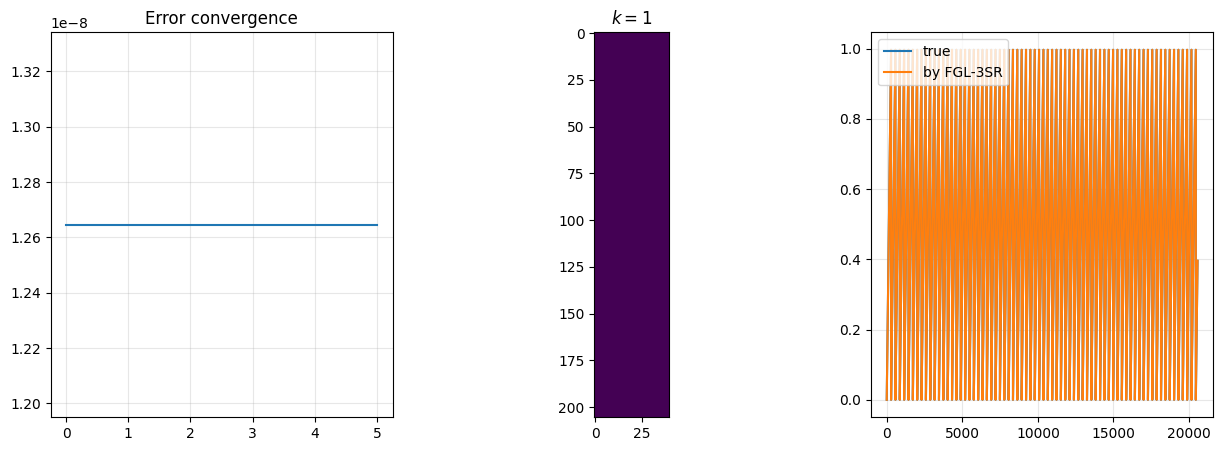

In [ ]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rcParams["figure.figsize"] = (15, 5)

plt.subplot(131)
plt.plot(err[1:])
plt.grid(alpha=.3)
plt.title("Error convergence")

plt.subplot(132)
plt.title('$k = $' + str(np.sum(np.sum(abs(H), 1)>0)))
plt.imshow(abs(H[1:, :40]))

plt.subplot(133)
plt.plot(Y[0], label="true")
plt.plot(X.dot(H)[0], label='by FGL-3SR')
plt.grid(alpha=.3)
plt.legend()